# Algoritmo de Deutsch-Jozsa

## Descripción general

El **Algoritmo de Deutsch-Jozsa** es una generalización del Algoritmo de Deutsch para una función `f(x)` que toma $n$ bits de entrada y devuelve 1 bit de salida ($f: \{0,1\}^n \to \{0,1\}$).

El algoritmo se basa en la **promesa** de que la función es una de dos tipos:
1.  **Constante:** La salida es la misma para todas las entradas (ej. `f(x) = 0` para todo `x`, o `f(x) = 1` para todo `x`).
2.  **Balanceada:** Exactamente la mitad de las entradas producen `0` y la otra mitad producen `1`.

### Recursos utilizados
- $n+1$ qubits (Usaremos $n=3$, por lo tanto, 4 qubits).
- $n$ bits clásicos (Usaremos 3 bits).
- 1 consulta al oráculo cuántico (`U_f`).

### Idea principal
Mientras que un computador clásico necesitaría, en el peor de los casos, $2^{n-1} + 1$ consultas para verificar la propiedad, el algoritmo de Deutsch-Jozsa lo resuelve con **una sola consulta** al oráculo, demostrando una ventaja cuántica exponencial.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import Aer
from qiskit_ibm_runtime import Sampler

# Cargar credenciales (este paso es opcional, se puede simular)
try:
    service = QiskitRuntimeService()  # usa cuenta previamente guardada
    backend = service.backend("ibm_brisbane") #Utilizamos Brisbane, pero se puede utilizar ibm_torino
    print("Conexión con IBM Quantum Platform exitoso")
except Exception:
    backend = Aer.get_backend("aer_simulator")
    print("Utilizando el simulador de AER")

Conexión con IBM Quantum Platform exitoso


## Procedimiento

El protocolo consta de **cinco etapas** principales (para $n$ bits de entrada):

1.  **Preparación de Registros:**
    * Se inicializan $n$ qubits de entrada (ej. `q0, q1, q2`) en el estado $|0\rangle$.
    * Se inicializa 1 qubit "ancilla" (`q3`) en el estado $|1\rangle$ (aplicando una compuerta `X`).

2.  **Superposición:**
    * Se aplica una compuerta Hadamard (`H`) a **todos** los $n+1$ qubits. Esto pone los qubits de entrada en una superposición de todos los $2^n$ estados posibles y la ancilla en el estado $|-\rangle$.

3.  **Oráculo:**
    * Se aplica el oráculo cuántico `U_f`, que codifica la función `f(x)`.

4.  **Interferencia:**
    * Se aplica una compuerta Hadamard (`H`) de nuevo, pero *solo* a los $n$ qubits de entrada.

5.  **Medición:**
    * Se miden *solo* los $n$ qubits de entrada.

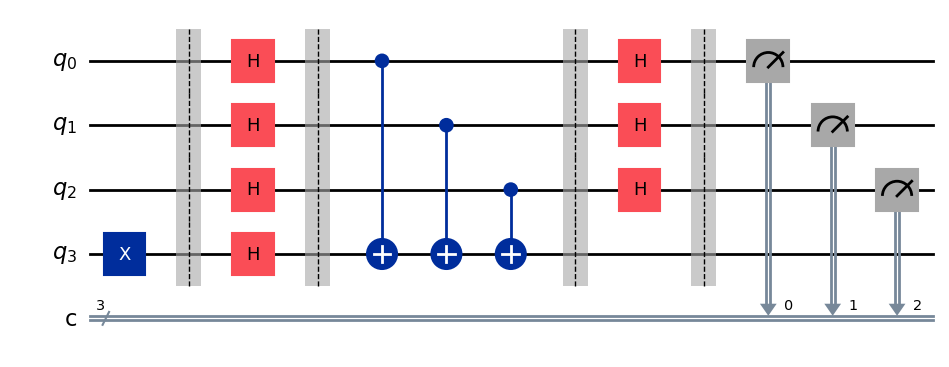

In [2]:
# Definir los registros (n=3) 
# 3 qubits de entrada (q0, q1, q2)
# 1 qubit ancilla (q3)
# 3 bits clásicos (c0, c1, c2)
qc = QuantumCircuit(4, 3)

# Preparación de Registros 
qc.x(3)          # Inicializamos ancilla (q3) en |1>
qc.barrier()

# Superposición 
qc.h([0, 1, 2, 3]) # Aplicamos H a todos los qubits
qc.barrier()

# Oráculo 
# Implementaremos un oráculo BALANCEADO: f(x) = x0 XOR x1 XOR x2
# Esto se implementa con CNOTs desde cada qubit de entrada
# hacia el qubit ancilla.
qc.cx(0, 3)
qc.cx(1, 3)
qc.cx(2, 3)
qc.barrier()

# Interferencia 
qc.h([0, 1, 2]) # Aplicamos H solo a los qubits de entrada
qc.barrier()

#  Medición 
qc.measure([0, 1, 2], [0, 1, 2]) # Medimos solo los qubits de entrada

# Dibujar el circuito 
qc.draw("mpl")

### Explicación del circuito
- **Registros:** `q0, q1, q2` son la entrada $x$. `q3` es la ancilla. `c0, c1, c2` almacenan el resultado.
- **Preparación:** La ancilla se prepara en el estado $|-\rangle$ (usando `X` y `H`). Los qubits de entrada se preparan en una superposición uniforme de todos los 8 estados posibles (de `000` a `111`).
- **Oráculo:** Los tres `CX` implementan la función $f(x_2, x_1, x_0) = x_0 \oplus x_1 \oplus x_2$. Esta función es **balanceada** (devuelve 0 para 4 entradas y 1 para las otras 4).
- **Interferencia:** Las compuertas Hadamard finales hacen que los resultados de la función interfieran.
- **Medición:** Medimos solo los qubits de entrada, ya que la respuesta al problema se codifica allí.

Transpilando el circuito para el backend...
Transpilación completada.
Enviando trabajo al Sampler...
Trabajo completado.
Resultados de la medición de los qubits de entrada:


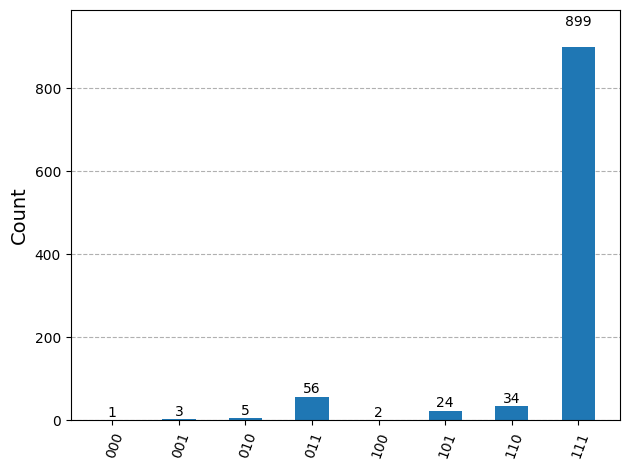

In [3]:
# Ejecución del circuito 

# Transpila tu circuito lógico 'qc' para el 'backend'
print("Transpilando el circuito para el backend...")
tqc = transpile(qc, backend=backend)
print("Transpilación completada.")

# Instancia el Sampler (Primitivo V2) pasando el backend
sampler = Sampler(mode=backend)
print("Enviando trabajo al Sampler...")

# Ejecuta el .run() con el circuito yatranspilado (tqc) y los shots
job = sampler.run([tqc], shots=1024) 
result = job.result()
print("Trabajo completado.")

# Obtén los resultados del formato V2
pub_result = result[0]
counts = pub_result.data.c.get_counts()

# Visualización
print("Resultados de la medición de los qubits de entrada:")
plot_histogram(counts)

### Interpretación de resultados
- El histograma muestra el resultado de la medición de los 3 bits de entrada.
- **La teoría predice:**
    - Si la función es **Constante**, la interferencia es perfectamente constructiva hacia el estado `000`. La medición *siempre* será `000`.
    - Si la función es **Balanceada**, la interferencia es perfectamente destructiva para el estado `000`. La medición *nunca* será `000`.
- **Nuestro Resultado:**
    - Implementamos una función **balanceada**.
    - Por lo tanto, en un simulador ideal, la barra `000` debería tener 0 cuentas.
    - El histograma debería mostrar una distribución de probabilidad sobre *todos los demás estados* (`001`, `010`, ..., `111`).
    - Si se usa hardware real, la barra `000` puede aparecer, pero será muy pequeña en comparación con las demás, indicando el ruido del sistema.

## Conclusión

El algoritmo de Deutsch-Jozsa demuestra de manera contundente el poder del paralelismo cuántico.

- Al consultar el oráculo una sola vez sobre un estado de superposición, la computadora cuántica evalúa la función para **todas las $2^n$ entradas posibles** simultáneamente.
- El truco final de las compuertas Hadamard (interferencia) provoca que todas estas $2^n$ piezas de información colapsen en una única respuesta global: "000" (Constante) o "cualquier otra cosa" (Balanceada).
- Este fue el primer algoritmo en demostrar una **ventaja cuántica exponencial** (en términos de consultas) sobre su contraparte clásica para un problema específico.